In [ ]:
# DPB-Bert

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def scale_data(train_data, test_data):
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    return pd.DataFrame(scaled_train_data, columns=train_data.columns), pd.DataFrame(scaled_test_data, columns=test_data.columns)
 
def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc=False):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=10, return_train_score=True)
    grid_search.fit(X_train, y_train)
 
    best_model = grid_search.best_estimator_
 
    print(f"\nResults for {model.__class__.__name__} - Cross Validation:")
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []
    mean_accuracy_list = []
 
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
 
        fold_model = model.__class__(**best_model.get_params())
        fold_model.fit(X_train_fold, y_train_fold)
        predictions = fold_model.predict(X_val_fold)
 
        fpr, tpr, _ = roc_curve(y_val_fold, fold_model.predict_proba(X_val_fold)[:, 1])
        roc_auc = auc(fpr, tpr)
 
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Fold {fold} (AUC = {roc_auc:.2f})')
 
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tpr_list.append(interp_tpr)
        
        fold_accuracy = accuracy_score(y_val_fold, predictions)
        print(f"\nFold {fold} Accuracy: {fold_accuracy}")
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val_fold, predictions))
        mean_accuracy_list.append(fold_accuracy)
 
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model.__class__.__name__} (Cross Validation)')
    plt.legend(loc='lower right')
 
    if save_auroc:
        plt.savefig(f"{model.__class__.__name__}_CrossValidation_ROC.pdf")
    plt.show()
    plt.close()
 
    # Evaluate on testing set
    predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, predictions)
    test_roc_auc = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
 
    print("\nResults for", model.__class__.__name__, "- Testing:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("\nClassification Report:\n", classification_report(y_test, predictions))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    print("Precision for Class 0:", precision[0])
    print("Recall for Class 0:", recall[0])
    print("F1-Score for Class 0:", f1[0])
 
    print("Precision for Class 1:", precision[1])
    print("Recall for Class 1:", recall[1])
    print("F1-Score for Class 1:", f1[1])
 
    print("\nMatthews Correlation Coefficient:", matthews_corrcoef(y_test, predictions))
    print("\nTest AUC Score:", auc(test_roc_auc[0], test_roc_auc[1]))


In [3]:
def svm_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.01, 0.1, 1, 10, 100, 1000]
    }
 
    svm_model = SVC(probability=True)
    train_and_evaluate(svm_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [4]:
def random_forest_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8, 16, 20]
    }
 
    rf_model = RandomForestClassifier()
    train_and_evaluate(rf_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [5]:
def adaboost_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
 
    adaboost_model = AdaBoostClassifier()
    train_and_evaluate(adaboost_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [6]:
def xgboost_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
 
    xgb_model = XGBClassifier()
    train_and_evaluate(xgb_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [7]:
def extratrees_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
 
    extratrees_model = ExtraTreesClassifier()
    train_and_evaluate(extratrees_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)


In [8]:
training_data = pd.read_csv("df_train_feature_pb.csv", index_col=0)
testing_data = pd.read_csv("df_test_feature_pb.csv", index_col=0)

In [9]:
# Separate features and labels
X_train_data = training_data.drop('Label', axis=1)
y_train_data = training_data['Label']
X_test_data = testing_data.drop('Label', axis=1)
y_test_data = testing_data['Label']

In [10]:
scaled_X_train, scaled_X_test = scale_data(X_train_data, X_test_data)

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


KeyboardInterrupt




Results for RandomForestClassifier - Cross Validation:

Fold 1 Accuracy: 0.753968253968254

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76       252
           1       0.76      0.75      0.75       252

    accuracy                           0.75       504
   macro avg       0.75      0.75      0.75       504
weighted avg       0.75      0.75      0.75       504


Fold 2 Accuracy: 0.753968253968254

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       252
           1       0.77      0.73      0.75       252

    accuracy                           0.75       504
   macro avg       0.75      0.75      0.75       504
weighted avg       0.75      0.75      0.75       504


Fold 3 Accuracy: 0.7658730158730159

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0

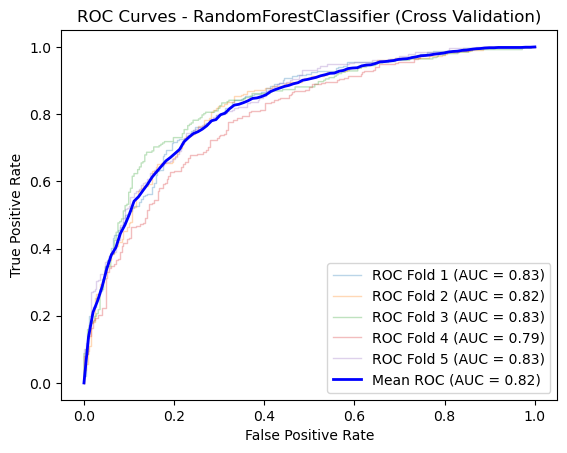


Results for RandomForestClassifier - Testing:
Accuracy: 0.7968253968253968

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78       315
           1       0.76      0.86      0.81       315

    accuracy                           0.80       630
   macro avg       0.80      0.80      0.80       630
weighted avg       0.80      0.80      0.80       630

Precision for Class 0: 0.8375451263537906
Recall for Class 0: 0.7365079365079366
F1-Score for Class 0: 0.7837837837837839
Precision for Class 1: 0.7648725212464589
Recall for Class 1: 0.8571428571428571
F1-Score for Class 1: 0.808383233532934

Matthews Correlation Coefficient: 0.598018155750419

Test AUC Score: 0.8627462836986646


In [49]:
random_forest_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


Results for AdaBoostClassifier - Cross Validation:

Fold 1 Accuracy: 0.7380952380952381

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       252
           1       0.72      0.77      0.75       252

    accuracy                           0.74       504
   macro avg       0.74      0.74      0.74       504
weighted avg       0.74      0.74      0.74       504


Fold 2 Accuracy: 0.746031746031746

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       252
           1       0.76      0.72      0.74       252

    accuracy                           0.75       504
   macro avg       0.75      0.75      0.75       504
weighted avg       0.75      0.75      0.75       504


Fold 3 Accuracy: 0.75

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74    

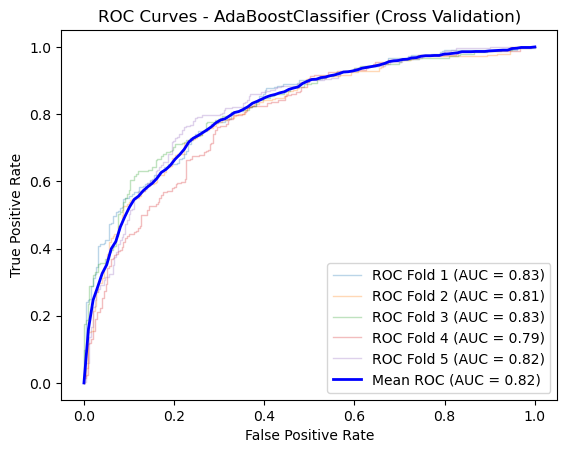


Results for AdaBoostClassifier - Testing:
Accuracy: 0.7761904761904762

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75       315
           1       0.74      0.86      0.79       315

    accuracy                           0.78       630
   macro avg       0.78      0.78      0.77       630
weighted avg       0.78      0.78      0.77       630

Precision for Class 0: 0.8346153846153846
Recall for Class 0: 0.6888888888888889
F1-Score for Class 0: 0.7547826086956522
Precision for Class 1: 0.7351351351351352
Recall for Class 1: 0.8634920634920635
F1-Score for Class 1: 0.7941605839416059

Matthews Correlation Coefficient: 0.5609985157906701

Test AUC Score: 0.8772688334593096


In [51]:
adaboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


Results for ExtraTreesClassifier - Cross Validation:

Fold 1 Accuracy: 0.746031746031746

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74       252
           1       0.73      0.77      0.75       252

    accuracy                           0.75       504
   macro avg       0.75      0.75      0.75       504
weighted avg       0.75      0.75      0.75       504


Fold 2 Accuracy: 0.7321428571428571

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.74       252
           1       0.74      0.71      0.73       252

    accuracy                           0.73       504
   macro avg       0.73      0.73      0.73       504
weighted avg       0.73      0.73      0.73       504


Fold 3 Accuracy: 0.7440476190476191

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.

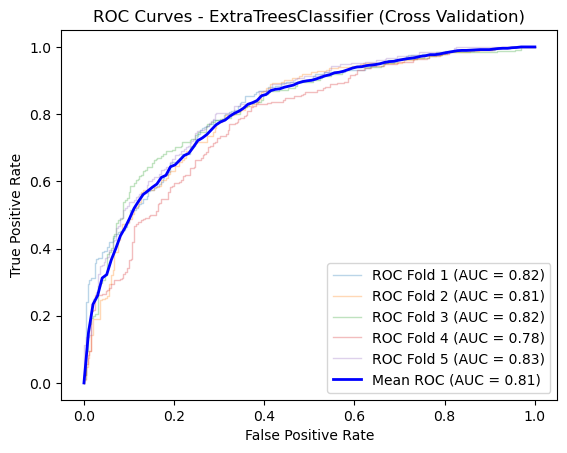


Results for ExtraTreesClassifier - Testing:
Accuracy: 0.7793650793650794

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.69      0.76       315
           1       0.74      0.87      0.80       315

    accuracy                           0.78       630
   macro avg       0.79      0.78      0.78       630
weighted avg       0.79      0.78      0.78       630

Precision for Class 0: 0.8410852713178295
Recall for Class 0: 0.6888888888888889
F1-Score for Class 0: 0.7574171029668412
Precision for Class 1: 0.7365591397849462
Recall for Class 1: 0.8698412698412699
F1-Score for Class 1: 0.7976710334788938

Matthews Correlation Coefficient: 0.5681085754545895

Test AUC Score: 0.8563567649281935


In [52]:
extratrees_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

In [ ]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Results for XGBClassifier - Cross Validation:


/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 1 Accuracy: 0.7777777777777778

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77       252
           1       0.77      0.80      0.78       252

    accuracy                           0.78       504
   macro avg       0.78      0.78      0.78       504
weighted avg       0.78      0.78      0.78       504



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i


Fold 2 Accuracy: 0.7698412698412699

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       252
           1       0.78      0.75      0.77       252

    accuracy                           0.77       504
   macro avg       0.77      0.77      0.77       504
weighted avg       0.77      0.77      0.77       504



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical


Fold 3 Accuracy: 0.7619047619047619

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77       252
           1       0.77      0.75      0.76       252

    accuracy                           0.76       504
   macro avg       0.76      0.76      0.76       504
weighted avg       0.76      0.76      0.76       504



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)


Fold 4 Accuracy: 0.7395626242544732

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       251
           1       0.74      0.75      0.74       252

    accuracy                           0.74       503
   macro avg       0.74      0.74      0.74       503
weighted avg       0.74      0.74      0.74       503



/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spa


Fold 5 Accuracy: 0.7395626242544732

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74       252
           1       0.74      0.73      0.74       251

    accuracy                           0.74       503
   macro avg       0.74      0.74      0.74       503
weighted avg       0.74      0.74      0.74       503



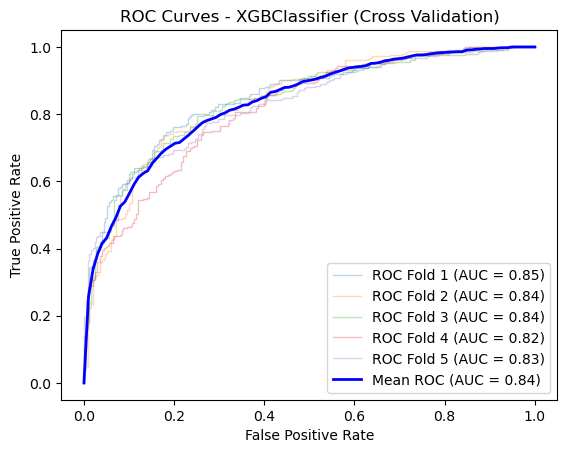


Results for XGBClassifier - Testing:
Accuracy: 0.792063492063492

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.78       315
           1       0.76      0.86      0.81       315

    accuracy                           0.79       630
   macro avg       0.80      0.79      0.79       630
weighted avg       0.80      0.79      0.79       630

Precision for Class 0: 0.8407407407407408
Recall for Class 0: 0.7206349206349206
F1-Score for Class 0: 0.7760683760683762
Precision for Class 1: 0.7555555555555555
Recall for Class 1: 0.8634920634920635
F1-Score for Class 1: 0.8059259259259258

Matthews Correlation Coefficient: 0.5901802751716174

Test AUC Score: 0.898140589569161


/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

In [16]:
xgboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

In [30]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
random_forest_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
adaboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
xgboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
extratrees_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


KeyboardInterrupt

